In [2]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm
#!pip install mlxtend

In [3]:
import pandas as pd
import numpy as np
import seaborn as sn

import catboost as cat
import xgboost as xgb
#import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_absolute_error

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from itertools import cycle
#import cPickle

from os import listdir

from datetime import datetime
import time
pd.set_option("display.max_rows", None)

In [4]:
# First we define the error rate for predictions
def error_rate(model,y_test,X_test):
    """Calculates the error rate for a machine learning classification model given a model, a dataset with all the instances and the predicted value"""
    y_pred = model.predict(X_test)
    #error rate
    error = 1.0 - metrics.accuracy_score(y_test, y_pred)
    return error

#function - training / test for a given m - bagging approach
def train_test_bagging(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

#function - training / test for a given m - bagging approach
def train_test_baggingK(m, X_app, y_app, X_test, y_test, rdm):
    """Calculates the error rate for a given set of data used in a bagging classifier and a given value of m number of estimators"""
    bag = BaggingClassifier(KNeighborsClassifier(), n_estimators=m, random_state=rdm)
    bag.fit(X_app,y_app)
    return error_rate(bag, y_test, X_test)
#end train-test

In [5]:
file_suffix = "_proportional_Dataset5_top15"


#df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-16_09_59_01.csv")
df_training_videos = pd.read_csv("./model/training_videos_attributes2022-01-11_06_52_14.csv")
print("Number of records (original set):", len(df_training_videos))
df_training_videos.head()

Number of records (original set): 34766


,video,title,duration,view_count,width,height,description_snippet,channel_id,channel_title,published_time,...,nrc_el_negative,nrc_el_positive,nrc_el_sadness,nrc_el_surprise,nrc_el_trust,nrc_el,Flesch,ARI,Flesch.Kincaid,bias
0,N3q-h2knovU,This liberal DA is facing pushback on his plan...,4:16,0,0,0,This liberal DA is facing pushback on his plan...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0.0,0.0,0.0,0.0,0.0,anger,119.190000,-13.650000,-2.620000,R
1,aPmYO9ZF12M,Gingrich: Americans sense that our best days a...,5:43,0,0,0,Gingrich: Americans sense that our best days a...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,27.0,42.0,17.0,9.0,23.0,positive,-954.208488,511.568839,400.990829,R
2,TBq6hKlHubE,Teachers union hit with lawsuit over school cl...,4:10,0,0,0,Teachers union hit with lawsuit over school cl...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0.0,0.0,0.0,0.0,0.0,anger,NaN,NaN,NaN,R
3,SexfFbs0MZ8,These are the big liars: Steve Hilton,9:39,0,0,0,These are the big liars: Steve Hilton,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0.0,0.0,0.0,0.0,0.0,anger,120.205000,-13.365000,-3.010000,R
4,3oGRmQm-STc,Gowdy: This is anti-democratic,3:06,0,0,0,Gowdy: This is anti-democratic,UCXIJgqnII2ZOINSWNOGFThA,Fox News,9999 days ago,...,0.0,0.0,0.0,0.0,0.0,anger,118.175000,-12.365000,-2.230000,R


In [6]:
df_training_videos = df_training_videos[pd.notnull(df_training_videos["bias"])]
df_training_videos = df_training_videos[df_training_videos["length"] > 0]
df_training_videos.dropna(subset=["Flesch"], inplace=True)
print("Number of records with known bias (original set):", len(df_training_videos))

Number of records with known bias (original set): 15079


In [7]:
df_training_videos.bias.value_counts()

LC    8830
C     2957
RC    1693
L     1366
R      233
Name: bias, dtype: int64

In [8]:
df_training_videos.loc[df_training_videos["bias"]=="L", "bias_num"] = 1
df_training_videos.loc[df_training_videos["bias"]=="LC", "bias_num"] = 2
df_training_videos.loc[df_training_videos["bias"]=="C", "bias_num"] = 3
df_training_videos.loc[df_training_videos["bias"]=="RC", "bias_num"] = 4
df_training_videos.loc[df_training_videos["bias"]=="R", "bias_num"] = 5

In [9]:
df_training_videos["lsd_count"] = df_training_videos["lsd_negative"] + df_training_videos["lsd_positive"]
df_training_videos["lsd_pct"] = df_training_videos["lsd_count"] / df_training_videos["length"]

df_training_videos["afinn_count"] = df_training_videos["afinn_negative"] + df_training_videos["afinn_positive"]
df_training_videos["afinn_pct"] = df_training_videos["afinn_count"] / df_training_videos["length"]

df_training_videos["geninqposneg_count"] = df_training_videos["geninqposneg_negative"] + df_training_videos["geninqposneg_positive"]
df_training_videos["geninqposneg_pct"] = df_training_videos["geninqposneg_count"] / df_training_videos["length"]

df_training_videos["huliu_count"] = df_training_videos["huliu_negative"] + df_training_videos["huliu_positive"]
df_training_videos["huliu_pct"] = df_training_videos["huliu_count"] / df_training_videos["length"]

df_training_videos["lm_count"] = df_training_videos["lm_negative"] + df_training_videos["lm_positive"] + df_training_videos["lm_uncertainty"] + df_training_videos["lm_litigious"] + df_training_videos["lm_constraining"] + df_training_videos["lm_superfluous"] + df_training_videos["lm_interesting"] + df_training_videos["lm_modal_words_strong"]
df_training_videos["lm_pct"] = df_training_videos["lm_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_negative_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_positive_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_uncertainty_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_litigious_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_constraining_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_superfluous_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_interesting_pct"] = 0
df_training_videos.loc[df_training_videos["lm_count"] == 0, "lm_modal_words_strong_pct"] = 0

df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_negative_pct"] = df_training_videos["lm_negative"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_positive_pct"] = df_training_videos["lm_positive"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_uncertainty_pct"] = df_training_videos["lm_uncertainty"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_litigious_pct"] = df_training_videos["lm_litigious"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_constraining_pct"] = df_training_videos["lm_constraining"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_superfluous_pct"] = df_training_videos["lm_superfluous"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_interesting_pct"] = df_training_videos["lm_interesting"] / df_training_videos["lm_count"]
df_training_videos.loc[df_training_videos["lm_count"] > 0, "lm_modal_words_strong_pct"] = df_training_videos["lm_modal_words_strong"] / df_training_videos["lm_count"]

df_training_videos["lgpp_count"] = df_training_videos["lgpp_culture"] + df_training_videos["lgpp_economy"] + df_training_videos["lgpp_environment"] + df_training_videos["lgpp_groups"] + df_training_videos["lgpp_institutions"] + df_training_videos["lgpp_law_and_order"] + df_training_videos["lgpp_rural"] + df_training_videos["lgpp_urban"] + df_training_videos["lgpp_values"]
df_training_videos["lgpp_pct"] = df_training_videos["lgpp_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_culture_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_economy_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_environment_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_groups_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_institutions_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_law_and_order_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_rural_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_urban_pct"] = 0
df_training_videos.loc[df_training_videos["lgpp_count"] == 0, "lgpp_values_pct"] = 0

df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_culture_pct"] = df_training_videos["lgpp_culture"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_economy_pct"] = df_training_videos["lgpp_economy"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_environment_pct"] = df_training_videos["lgpp_environment"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_groups_pct"] = df_training_videos["lgpp_groups"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_institutions_pct"] = df_training_videos["lgpp_institutions"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_law_and_order_pct"] = df_training_videos["lgpp_law_and_order"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_rural_pct"] = df_training_videos["lgpp_rural"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_urban_pct"] = df_training_videos["lgpp_urban"] / df_training_videos["lgpp_count"]
df_training_videos.loc[df_training_videos["lgpp_count"] > 0, "lgpp_values_pct"] = df_training_videos["lgpp_values"] / df_training_videos["lgpp_count"]

df_training_videos["nrc_el_count"] = df_training_videos["nrc_el_anger"] + df_training_videos["nrc_el_anticipation"] + df_training_videos["nrc_el_disgust"] + df_training_videos["nrc_el_fear"] + df_training_videos["nrc_el_joy"] + df_training_videos["nrc_el_negative"] + df_training_videos["nrc_el_positive"] + df_training_videos["nrc_el_sadness"] + df_training_videos["nrc_el_surprise"] + df_training_videos["nrc_el_trust"]
df_training_videos["nrc_el_pct"] = df_training_videos["nrc_el_count"] / df_training_videos["length"]

df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_anger_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_anticipation_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_disgust_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_fear_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_joy_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_negative_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_positive_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_sadness_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_surprise_pct"] = 0
df_training_videos.loc[df_training_videos["nrc_el_count"] == 0, "nrc_el_trust_pct"] = 0

df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_anger_pct"] = df_training_videos["nrc_el_anger"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_anticipation_pct"] = df_training_videos["nrc_el_anticipation"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_disgust_pct"] = df_training_videos["nrc_el_disgust"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_fear_pct"] = df_training_videos["nrc_el_fear"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_joy_pct"] = df_training_videos["nrc_el_joy"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_negative_pct"] = df_training_videos["nrc_el_negative"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_positive_pct"] = df_training_videos["nrc_el_positive"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_sadness_pct"] = df_training_videos["nrc_el_sadness"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_surprise_pct"] = df_training_videos["nrc_el_surprise"] / df_training_videos["nrc_el_count"]
df_training_videos.loc[df_training_videos["nrc_el_count"] > 0, "nrc_el_trust_pct"] = df_training_videos["nrc_el_trust"] / df_training_videos["nrc_el_count"]

In [10]:
# Creation of modelling datasets

df_training_videos_l = df_training_videos[df_training_videos["bias"] == "L"]
df_training_videos_cl = df_training_videos[df_training_videos["bias"] == "LC"]
df_training_videos_c = df_training_videos[df_training_videos["bias"] == "C"]
df_training_videos_cr = df_training_videos[df_training_videos["bias"] == "RC"]
df_training_videos_r = df_training_videos[df_training_videos["bias"] == "R"]

# Creation of a dataset based on the class with the least instances

l_videos = 4000
cl_videos = 4000
c_videos = 4000
cr_videos = 4000
r_videos = 4000

df_training_videos_0 = df_training_videos_l.sample(n = min(l_videos, len(df_training_videos_l))) # The df on the left is numbered "1" (one) while the one on the right is "l" (the letter l, for left)
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cl.sample(n = min(cl_videos, len(df_training_videos_cl))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_c.sample(n = min(c_videos, len(df_training_videos_c))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_cr.sample(n = min(cr_videos, len(df_training_videos_cr))))
df_training_videos_0 = df_training_videos_0.append(df_training_videos_r.sample(n = min(r_videos, len(df_training_videos_r))))

In [11]:
df_training_videos_0.bias.value_counts()

LC    4000
C     2957
RC    1693
L     1366
R      233
Name: bias, dtype: int64

In [12]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/training_videos_0" + file_suffix+ date + ".csv"
df_training_videos_0.to_csv(file_name, index=False)

In [13]:
df_training_videos_0 = df_training_videos_0[df_training_videos_0.columns[62:]].drop("bias", axis = 1)

In [14]:
df_training_videos_0.columns

Index(['Flesch', 'ARI', 'Flesch.Kincaid', 'bias_num', 'lsd_count', 'lsd_pct',
       'afinn_count', 'afinn_pct', 'geninqposneg_count', 'geninqposneg_pct',
       'huliu_count', 'huliu_pct', 'lm_count', 'lm_pct', 'lm_negative_pct',
       'lm_positive_pct', 'lm_uncertainty_pct', 'lm_litigious_pct',
       'lm_constraining_pct', 'lm_superfluous_pct', 'lm_interesting_pct',
       'lm_modal_words_strong_pct', 'lgpp_count', 'lgpp_pct',
       'lgpp_culture_pct', 'lgpp_economy_pct', 'lgpp_environment_pct',
       'lgpp_groups_pct', 'lgpp_institutions_pct', 'lgpp_law_and_order_pct',
       'lgpp_rural_pct', 'lgpp_urban_pct', 'lgpp_values_pct', 'nrc_el_count',
       'nrc_el_pct', 'nrc_el_anger_pct', 'nrc_el_anticipation_pct',
       'nrc_el_disgust_pct', 'nrc_el_fear_pct', 'nrc_el_joy_pct',
       'nrc_el_negative_pct', 'nrc_el_positive_pct', 'nrc_el_sadness_pct',
       'nrc_el_surprise_pct', 'nrc_el_trust_pct'],
      dtype='object')

In [15]:
bias_col = df_training_videos_0.pop("bias_num")
df_training_videos_0.insert(0, "bias_num", bias_col)

In [16]:
seed = 47

In [17]:
df_training_videos_num_i = df_training_videos_0

In [18]:
X = df_training_videos_num_i.to_numpy()[:,1:]
y = df_training_videos_num_i.to_numpy()[:,0].astype('int')

,Flesch,ARI,Flesch.Kincaid,lsd_count,lsd_pct,afinn_count,afinn_pct,geninqposneg_count,geninqposneg_pct,huliu_count,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
Flesch,1.000000,-0.999989,-0.999991,-0.655090,0.025787,-0.638386,0.017280,-0.651803,-0.102468,-0.632588,...,-0.042931,0.028105,0.001622,-0.011040,0.027060,0.008301,-0.075992,0.024009,0.093656,-0.102801
ARI,-0.999989,1.000000,1.000000,0.655180,-0.025750,0.638680,-0.016434,0.652085,0.103885,0.632791,...,0.042745,-0.027426,-0.001478,0.010396,-0.025774,-0.008793,0.075692,-0.024180,-0.092686,0.102516
Flesch.Kincaid,-0.999991,1.000000,1.000000,0.655170,-0.025980,0.638650,-0.016640,0.652062,0.103522,0.632769,...,0.042660,-0.027644,-0.001582,0.010325,-0.025954,-0.008884,0.075596,-0.024209,-0.092905,0.102396
lsd_count,-0.655090,0.655180,0.655170,1.000000,0.031477,0.983255,0.023177,0.979466,0.129329,0.987950,...,0.038061,0.001382,0.037760,-0.008990,-0.017328,0.020931,0.057267,-0.031474,-0.045713,0.073927
lsd_pct,0.025787,-0.025750,-0.025980,0.031477,1.000000,0.019593,0.740624,-0.035231,0.600822,0.009530,...,0.210783,-0.127869,0.209918,0.126514,0.174941,0.131906,-0.121524,0.123344,0.156072,-0.042008
afinn_count,-0.638386,0.638680,0.638650,0.983255,0.019593,1.000000,0.071805,0.981443,0.165513,0.985425,...,0.027507,0.014605,0.030640,-0.029808,0.026820,-0.001887,0.050200,-0.032195,-0.023891,0.066564
afinn_pct,0.017280,-0.016434,-0.016640,0.023177,0.740624,0.071805,1.000000,0.001126,0.655984,0.028164,...,0.115152,-0.087954,0.126897,0.000954,0.325325,-0.020098,-0.135542,0.096638,0.231333,-0.073354
geninqposneg_count,-0.651803,0.652085,0.652062,0.979466,-0.035231,0.981443,0.001126,1.000000,0.155677,0.981700,...,0.004486,0.031301,0.013342,-0.045666,0.012865,-0.011605,0.078151,-0.046567,-0.029303,0.085137
geninqposneg_pct,-0.102468,0.103885,0.103522,0.129329,0.600822,0.165513,0.655984,0.155677,1.000000,0.141104,...,0.031175,0.056981,0.075593,-0.104126,0.415974,-0.058401,0.019102,0.035710,0.305893,0.013853
huliu_count,-0.632588,0.632791,0.632769,0.987950,0.009530,0.985425,0.028164,0.981700,0.141104,1.000000,...,0.029603,0.010927,0.044182,-0.025970,-0.000769,0.019772,0.052539,-0.027822,-0.033325,0.062845


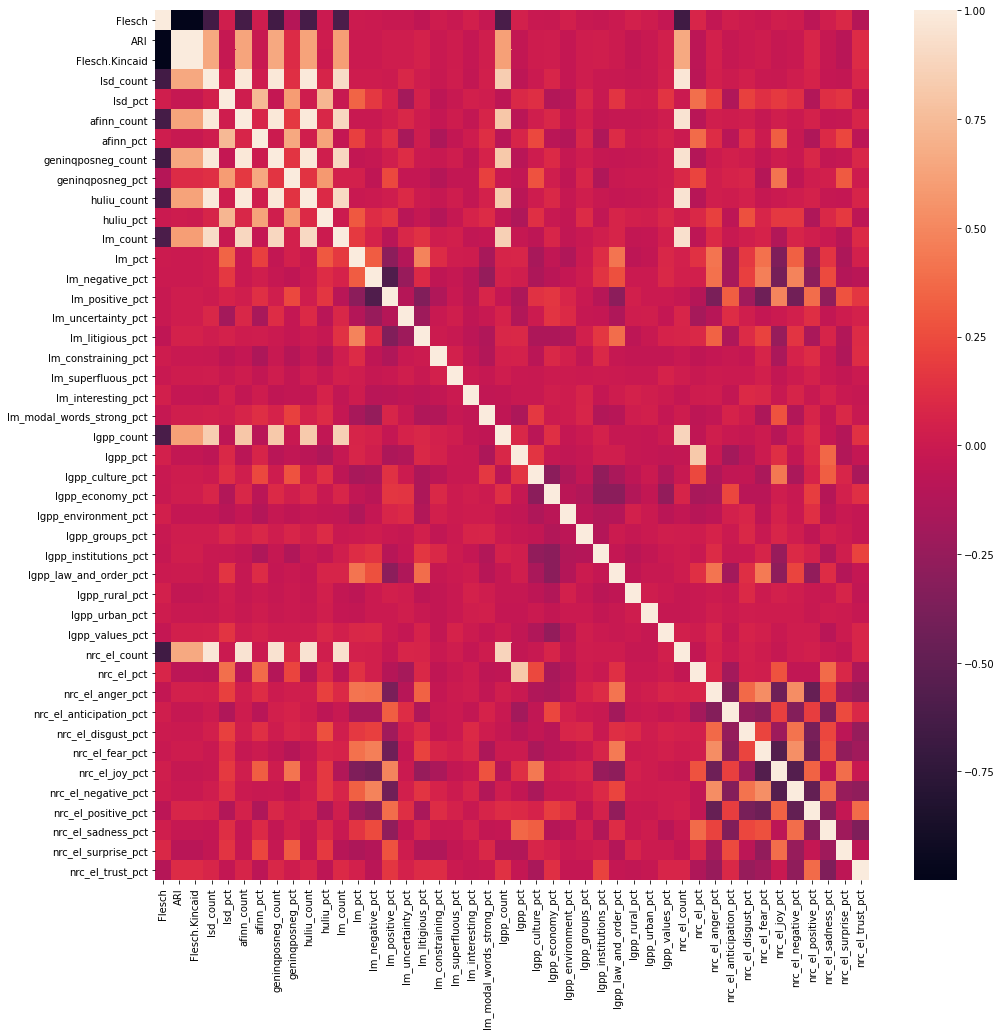

In [19]:
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

,Flesch,lsd_count,lsd_pct,lm_pct,lm_negative_pct,lm_positive_pct,lm_uncertainty_pct,lm_litigious_pct,lm_constraining_pct,lm_superfluous_pct,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
Flesch,1.000000,-0.655090,0.025787,0.001463,-0.000493,-0.016889,-0.018838,-0.054973,0.011675,-0.012854,...,-0.042931,0.028105,0.001622,-0.011040,0.027060,0.008301,-0.075992,0.024009,0.093656,-0.102801
lsd_count,-0.655090,1.000000,0.031477,0.009929,0.011749,0.005329,0.085144,0.019118,-0.017113,0.020897,...,0.038061,0.001382,0.037760,-0.008990,-0.017328,0.020931,0.057267,-0.031474,-0.045713,0.073927
lsd_pct,0.025787,0.031477,1.000000,0.348099,0.166789,0.059643,-0.186082,0.054634,-0.069410,-0.023365,...,0.210783,-0.127869,0.209918,0.126514,0.174941,0.131906,-0.121524,0.123344,0.156072,-0.042008
lm_pct,0.001463,0.009929,0.348099,1.000000,0.315868,-0.296512,-0.112883,0.484292,0.106957,0.020721,...,0.415875,-0.164092,0.165081,0.401893,-0.357780,0.333874,-0.209856,0.152518,-0.143011,0.046555
lm_negative_pct,-0.000493,0.011749,0.166789,0.315868,1.000000,-0.583207,-0.236442,0.098811,-0.058723,-0.025801,...,0.401744,-0.167103,0.196241,0.467324,-0.403477,0.477020,-0.294703,0.243685,-0.114595,-0.082943
lm_positive_pct,-0.016889,0.005329,0.059643,-0.296512,-0.583207,1.000000,-0.102483,-0.350567,-0.127024,-0.010704,...,-0.377105,0.323679,-0.200477,-0.435639,0.489437,-0.419013,0.384523,-0.278553,0.275180,0.161087
lm_uncertainty_pct,-0.018838,0.085144,-0.186082,-0.112883,-0.236442,-0.102483,1.000000,-0.214908,-0.014210,0.030464,...,-0.097905,0.109648,0.027947,-0.037285,-0.004999,0.038390,0.121563,-0.044320,0.013498,0.049252
lm_litigious_pct,-0.054973,0.019118,0.054634,0.484292,0.098811,-0.350567,-0.214908,1.000000,0.002506,-0.018348,...,0.339292,-0.139267,0.108765,0.215341,-0.248055,0.155705,-0.162246,0.067633,-0.117835,0.108970
lm_constraining_pct,0.011675,-0.017113,-0.069410,0.106957,-0.058723,-0.127024,-0.014210,0.002506,1.000000,0.040894,...,-0.032464,-0.019186,-0.032077,0.066158,-0.148756,0.056172,0.117090,-0.021638,-0.130427,0.110256
lm_superfluous_pct,-0.012854,0.020897,-0.023365,0.020721,-0.025801,-0.010704,0.030464,-0.018348,0.040894,1.000000,...,0.005940,-0.007702,-0.002084,0.038947,-0.043922,0.005002,0.049335,-0.012997,-0.040004,-0.004115


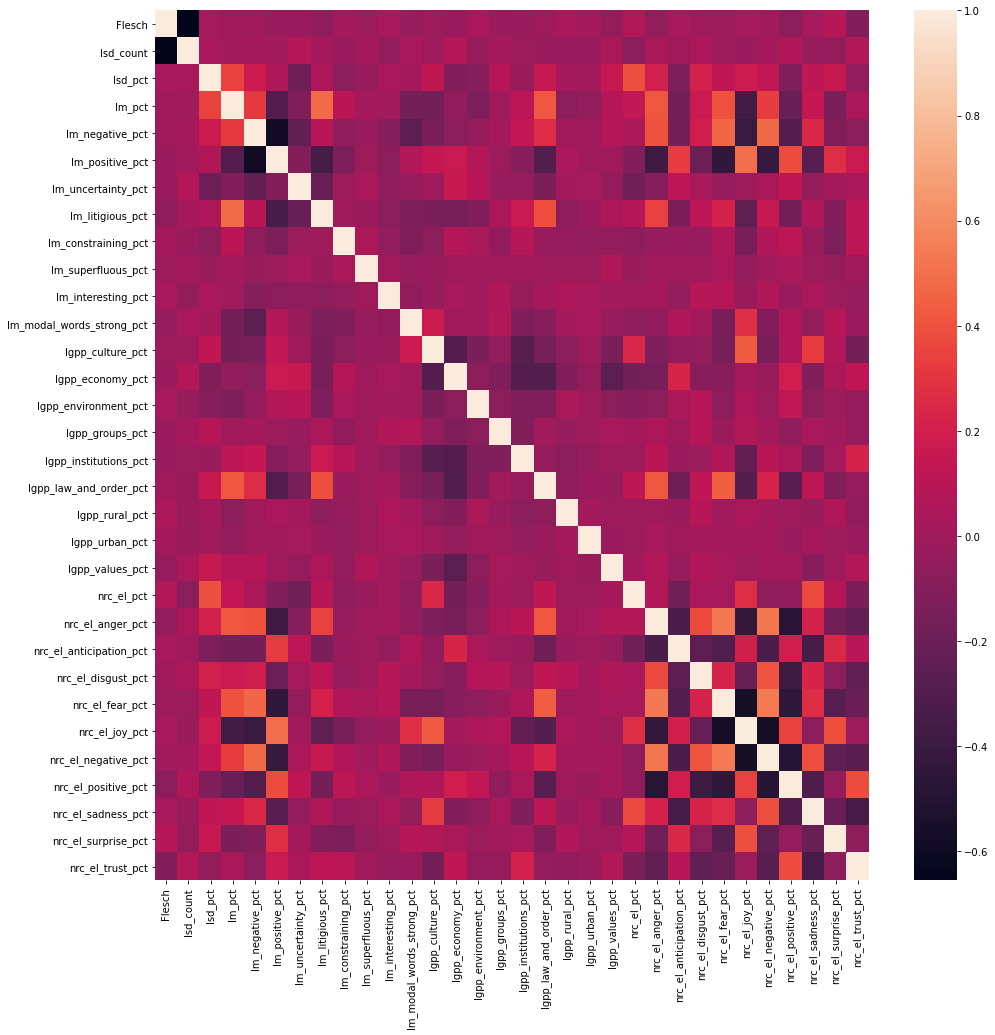

In [20]:
feature_drop = ["ARI", "Flesch.Kincaid", "afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "afinn_pct", "geninqposneg_pct", "huliu_pct"]
df_training_videos_num_i = df_training_videos_num_i.drop(feature_drop, axis = 1)
plt.figure(figsize=(16, 16))
sn.heatmap(df_training_videos_num_i.iloc[:,1:].corr())
df_training_videos_num_i.iloc[:,1:].corr()

In [21]:
X = df_training_videos_num_i.to_numpy()[:, 1:]
y = df_training_videos_num_i.to_numpy()[:, 0].astype('int')

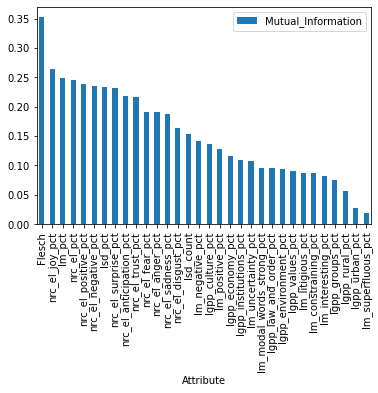

,Attribute,Mutual_Information
0,Flesch,0.352419
26,nrc_el_joy_pct,0.263777
3,lm_pct,0.249122
21,nrc_el_pct,0.245724
28,nrc_el_positive_pct,0.238422
27,nrc_el_negative_pct,0.235001
2,lsd_pct,0.233649
30,nrc_el_surprise_pct,0.232009
23,nrc_el_anticipation_pct,0.217285
31,nrc_el_trust_pct,0.215776


In [22]:
mic = mutual_info_classif(X, y, random_state=seed)
columns = df_training_videos_num_i.columns[1:]
mic_df = pd.DataFrame({'Attribute':df_training_videos_num_i.columns[1:], 'Mutual_Information':mic}).sort_values(by="Mutual_Information", ascending=False)
mic_df.plot('Attribute', 'Mutual_Information', kind='bar')
plt.show()
mic_df

In [23]:
feature_drop = ["lm_negative_pct", "lm_positive_pct", "lgpp_economy_pct", "lgpp_culture_pct", "lm_modal_words_strong_pct", "lgpp_institutions_pct", "lm_uncertainty_pct", "lgpp_law_and_order_pct", "lgpp_environment_pct", "lm_litigious_pct", "lm_constraining_pct", "lm_interesting_pct", "lgpp_values_pct", "lgpp_rural_pct", "lgpp_groups_pct", "lgpp_urban_pct", "lm_superfluous_pct"]
df_training_videos_num_i = df_training_videos_num_i.drop(feature_drop, axis = 1)
X = df_training_videos_num_i.to_numpy()[:, 1:]
y = df_training_videos_num_i.to_numpy()[:, 0].astype('int')


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## KNN

In [25]:
knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [26]:
parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
grid_knn = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_knn = grid_knn.fit(X_train, y_train)

best_estimators_knn = grille_knn.best_params_["n_neighbors"]
print("Best neighbors: ", best_estimators_knn)

best_score_knn = grille_knn.best_score_
print("Best score: ", best_score_knn)

knn = KNeighborsClassifier(n_neighbors=best_estimators_knn)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)

print("Random Forest Accuracy: ", knn_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   19.6s finished


Best neighbors:  20
Best score:  0.5355549599452039
Random Forest Accuracy:  0.5434146341463415


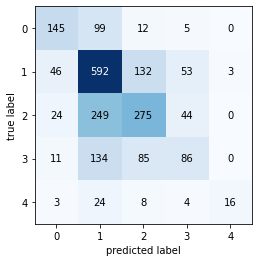

In [27]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_knn))
plt.show()

In [28]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", knn_accuracy)

Accuracy:  0.5434146341463415


In [29]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

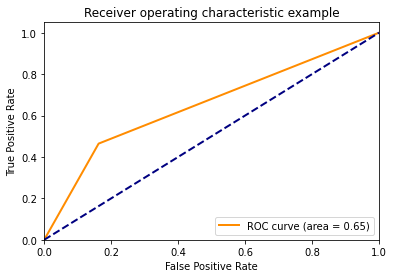

In [30]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

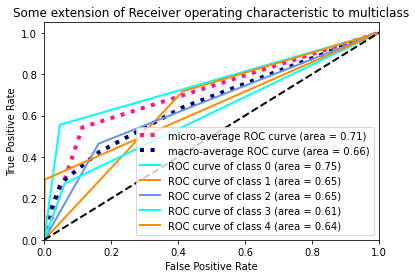

In [31]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [32]:
knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gaussian Naive Bayes

In [33]:
gnb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [34]:
#parametres = [{"n_neighbors":[10, 20, 30, 40, 50, 60]}]
#grid_gnb = GridSearchCV(cv = 10, estimator=KNeighborsClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)

#grille_gnb = grid_gnb.fit(X_train, y_train)

#best_estimators_gnb = grille_gnb.best_params_["n_neighbors"]
#print("Best neighbors: ", best_estimators_gnb)

#best_score_gnb = grille_gnb.best_score_
#print("Best score: ", best_score_gnb)

gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)

gnb_accuracy = metrics.accuracy_score(y_test, y_pred_gnb)

print("Random Forest Accuracy: ", gnb_accuracy)

Random Forest Accuracy:  0.4024390243902439


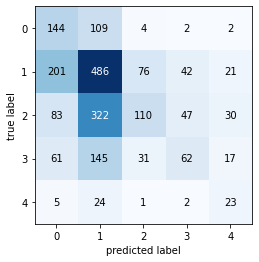

In [35]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_gnb))
plt.show()

In [36]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_gnb, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

gnb_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", gnb_accuracy)

Accuracy:  0.4024390243902439


In [37]:
gnb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

##  Random Forest

In [38]:
rf_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [39]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
grid_rf = GridSearchCV(cv = 10, estimator=RandomForestClassifier(), param_grid=parametres, scoring="accuracy", verbose = True)
grille_rf = grid_rf.fit(X_train, y_train)

best_estimators_rf = grille_rf.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_rf)

best_score_rf = grille_rf.best_score_
print("Best score: ", best_score_rf)

rf = RandomForestClassifier(n_estimators=best_estimators_rf, random_state=seed)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy: ", rf_accuracy)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.7min finished


Best estimators:  350
Best score:  0.780705649364186
Random Forest Accuracy:  0.7985365853658537


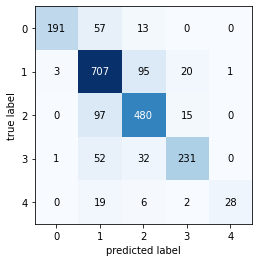

In [40]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_rf))
plt.show()

In [41]:
y_test_b = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_b = label_binarize(y_pred_rf, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

rf_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", rf_accuracy)

Accuracy:  0.7985365853658537


In [42]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

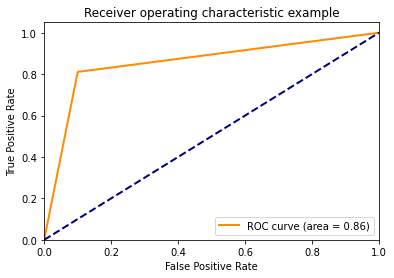

In [43]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

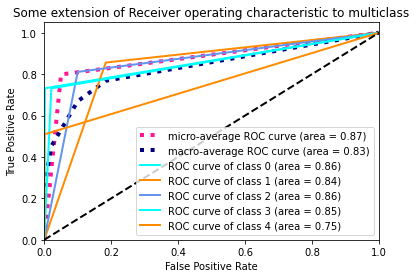

In [44]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [45]:
rf_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (Decision Tree Classifier)

In [46]:
bag_dtc_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.5min finished


Best estimators:  300
Best score:  0.7792410435093362
Bagging (Decision Tree Classifier) Accuracy:  0.8004878048780488


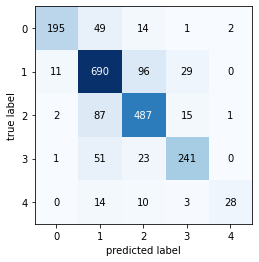

Accuracy:  0.8004878048780488


In [47]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_dtc = BaggingClassifier(DecisionTreeClassifier(), random_state=seed)
grid_bag_dtc = GridSearchCV(cv = 10, estimator=bag_dtc, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_dtc = grid_bag_dtc.fit(X_train, y_train)

best_estimators_bag_dtc = grille_bag_dtc.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_dtc)

best_score_bag_dtc = grille_bag_dtc.best_score_
print("Best score: ", best_score_bag_dtc)

bag_dtc = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_dtc, random_state=seed)
bag_dtc.fit(X_train,y_train)
y_pred_bag_dtc = bag_dtc.predict(X_test)

bag_dtc_accuracy = metrics.accuracy_score(y_test, y_pred_bag_dtc)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_dtc_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_dtc))
plt.show()

y_pred_b = label_binarize(y_pred_bag_dtc, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_dtc_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_dtc_accuracy)

In [48]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

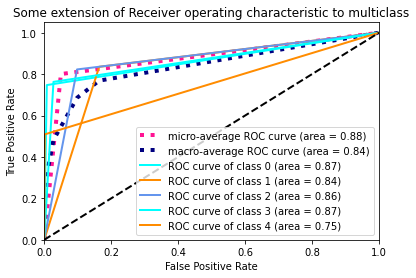

In [49]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [50]:
bag_dtc_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Bagging (K-Nearest Neighbour)

In [51]:
bag_knn_start = time.strftime("%Y-%m-%d_%H_%M_%S")

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 33.8min finished


Best estimators:  100
Best score:  0.5439698918967212
Bagging (Decision Tree Classifier) Accuracy:  0.7965853658536586


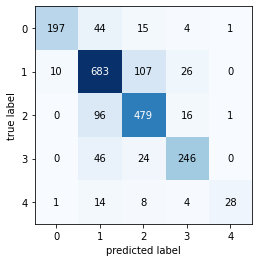

Accuracy:  0.7965853658536586


In [52]:
parametres = [{"n_estimators":[100, 150, 200, 250, 300, 350]}]
bag_knn = BaggingClassifier(KNeighborsClassifier(), random_state=seed)
grid_bag_knn = GridSearchCV(cv = 10, estimator=bag_knn, param_grid=parametres, scoring="accuracy", verbose=1)
grille_bag_knn = grid_bag_knn.fit(X_train, y_train)

best_estimators_bag_knn = grille_bag_knn.best_params_["n_estimators"]
print("Best estimators: ", best_estimators_bag_knn)

best_score_bag_knn = grille_bag_knn.best_score_
print("Best score: ", best_score_bag_knn)

bag_knn = BaggingClassifier(DecisionTreeClassifier(), n_estimators=best_estimators_bag_knn, random_state=seed)
bag_knn.fit(X_train, y_train)
y_pred_bag_knn = bag_knn.predict(X_test)

bag_knn_accuracy = metrics.accuracy_score(y_test, y_pred_bag_knn)

print("Bagging (Decision Tree Classifier) Accuracy: ", bag_knn_accuracy)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_bag_knn))
plt.show()

y_pred_b = label_binarize(y_pred_bag_knn, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

bag_knn_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)
print("Accuracy: ", bag_knn_accuracy)

In [53]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

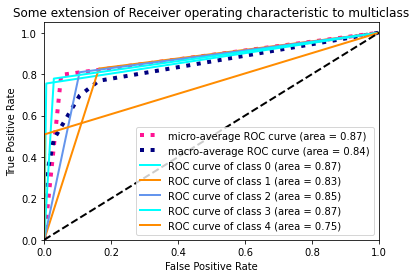

In [54]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [55]:
bag_knn_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Gradient Boosted Trees

In [56]:
cat_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [57]:
X_display = df_training_videos_num_i.drop('bias_num', axis = 1)
y_display = df_training_videos_num_i['bias_num'].to_numpy()

In [58]:
# create a train/test split with catboost
d_test_cat = cat.Pool(X_test, y_test)

In [59]:
model_cat = cat.CatBoostClassifier(iterations = 5000
                                   , learning_rate = 0.01
                                   , loss_function = "MultiClass"
                                   , random_seed = seed
#                                   , depth = 8)
                                   , depth = 4)

model_cat.fit(X_train
                , y_train
                , eval_set = d_test_cat
                , verbose_eval=500
                , early_stopping_rounds=400
                , plot = True)

y_pred_cat_array = model_cat.predict(X_test)

print("\nTest  Accuracy : %.2f"%model_cat.score(X_test, y_test))
print("Train Accuracy : %.2f"%model_cat.score(X_train, y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6036473	test: 1.6035735	best: 1.6035735 (0)	total: 141ms	remaining: 11m 42s
500:	learn: 1.0944927	test: 1.1039919	best: 1.1039919 (500)	total: 5.31s	remaining: 47.7s
1000:	learn: 1.0140369	test: 1.0412822	best: 1.0412822 (1000)	total: 10.1s	remaining: 40.4s
1500:	learn: 0.9558178	test: 1.0028947	best: 1.0028947 (1500)	total: 15.1s	remaining: 35.2s
2000:	learn: 0.9108780	test: 0.9790418	best: 0.9790418 (2000)	total: 20.5s	remaining: 30.7s
2500:	learn: 0.8742715	test: 0.9613864	best: 0.9613864 (2500)	total: 25.5s	remaining: 25.4s
3000:	learn: 0.8416140	test: 0.9459797	best: 0.9459700 (2999)	total: 30.8s	remaining: 20.5s
3500:	learn: 0.8117279	test: 0.9327910	best: 0.9327910 (3500)	total: 35.9s	remaining: 15.4s
4000:	learn: 0.7855468	test: 0.9216673	best: 0.9216673 (4000)	total: 41.6s	remaining: 10.4s
4500:	learn: 0.7602920	test: 0.9109975	best: 0.9109975 (4500)	total: 47s	remaining: 5.21s
4999:	learn: 0.7379282	test: 0.9012809	best: 0.9012809 (4999)	total: 53.2s	remaining: 0u

In [60]:
y_pred_cat = []
for i in range(len(y_pred_cat_array)):
    y_pred_cat.append(y_pred_cat_array[i][0])
y_pred_cat = np.asarray(y_pred_cat)

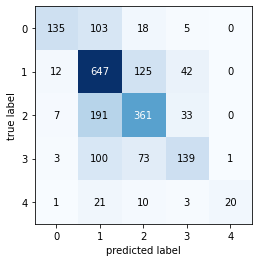

In [61]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_cat))
plt.show()

In [62]:
y_pred_b = label_binarize(y_pred_cat, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

cat_accuracy = metrics.accuracy_score(y_test_b, y_pred_b)

print("Accuracy: ", cat_accuracy)

Accuracy:  0.6351219512195122


In [63]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

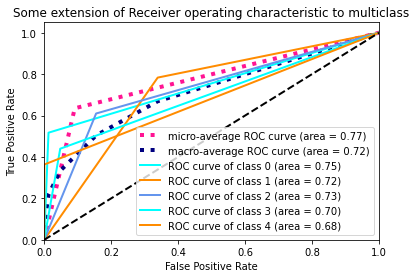

In [64]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [65]:
#file_name = "model/catboost_0" + date + ".cat"
#with open(file_name, 'wb') as fid:
    #cPickle.dump(bag, fid)

In [66]:
cat_end = time.strftime("%Y-%m-%d_%H_%M_%S")

El método **CatBoost** se detiene luego de 500 iteraciones al detectar posible overfitting, reprotando un error observado de 55% correspondiente a la iteración 390.

Además se probó una profundidad máxima de 4, arrojando el mismo error, llegando al resultado en 1247 iteraciones. También se probaron varios learning rate (0.02, 0.05, 0.001) con 4 de profundidad, obteninedo prácticamente el mismo error, con la notable diferencia de learning_rate de 0.001 que subía casi dos puntos.

Se conserva el modelo con depth=8 y learning_rate=0.01 como final.

## XGBoost

In [67]:
xgb_start = time.strftime("%Y-%m-%d_%H_%M_%S")

In [68]:
# create a train/test split with xgboost
d_train_xgb = xgb.DMatrix(X_train, label=y_train)
d_test_xgb = xgb.DMatrix(X_test, label=y_test)

In [69]:
params = {
    "learning_rate": 0.01,
    "objective": "multi:softmax",
    "num_class": 6,
    "eval_metric": "mlogloss",
    "max_depth": 4,
    "max_leaves": 4
}

model_xgb = xgb.train(params
                        , d_train_xgb
                        , 40000
                        , evals = [(d_test_xgb, "Test")]
                        , verbose_eval=1000
                        , early_stopping_rounds=1000)

y_pred_xgb_array = model_xgb.predict(d_test_xgb)
y_train_xgb_array = model_xgb.predict(d_train_xgb)

[0]	Test-mlogloss:1.78384
[1000]	Test-mlogloss:0.94689
[2000]	Test-mlogloss:0.87666
[3000]	Test-mlogloss:0.83131
[4000]	Test-mlogloss:0.79344
[5000]	Test-mlogloss:0.76580
[6000]	Test-mlogloss:0.74403
[7000]	Test-mlogloss:0.72521
[8000]	Test-mlogloss:0.70829
[9000]	Test-mlogloss:0.69726
[10000]	Test-mlogloss:0.68884
[11000]	Test-mlogloss:0.68238
[12000]	Test-mlogloss:0.67869
[13000]	Test-mlogloss:0.67658
[14000]	Test-mlogloss:0.67548
[14596]	Test-mlogloss:0.67545


In [70]:
y_train_xgb_array = model_xgb.predict(d_train_xgb)

In [71]:
print("\nTest  Accuracy : %.2f"%accuracy_score(y_test, y_pred_xgb_array))
print("Train Accuracy : %.2f"%accuracy_score(y_train, y_train_xgb_array))

print("\nClassification Report : ")
print(classification_report(y_test, y_pred_xgb_array))


Test  Accuracy : 0.79
Train Accuracy : 1.00

Classification Report : 
              precision    recall  f1-score   support

           1       0.93      0.76      0.84       261
           2       0.77      0.83      0.79       826
           3       0.76      0.78      0.77       592
           4       0.78      0.77      0.77       316
           5       0.96      0.49      0.65        55

    accuracy                           0.79      2050
   macro avg       0.84      0.72      0.76      2050
weighted avg       0.79      0.79      0.79      2050



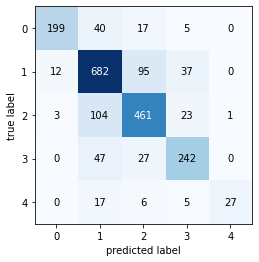

In [72]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred_xgb_array))
plt.show()

In [73]:
y_pred_xgb_array_b = label_binarize(y_pred_xgb_array, classes=[1, 2, 3, 4, 5])
n_classes = y_test_b.shape[1]

xgb_accuracy = metrics.accuracy_score(y_test_b, y_pred_xgb_array_b)

print("Accuracy: ", xgb_accuracy)

Accuracy:  0.7858536585365854


In [74]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_xgb_array_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_xgb_array_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

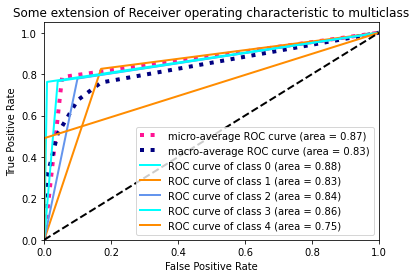

In [75]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

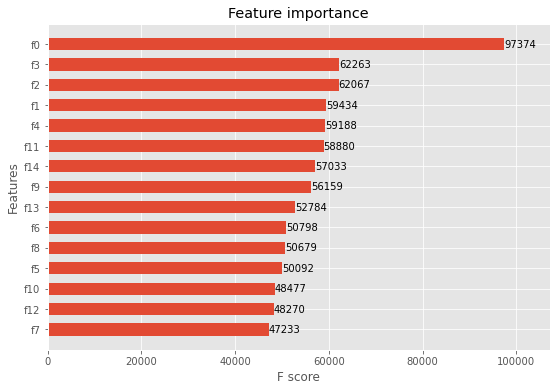

In [76]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(model_xgb, ax=ax, height=0.6, importance_type="weight")

In [77]:
xgb_end = time.strftime("%Y-%m-%d_%H_%M_%S")

## Metrics Summary

In [78]:
print("Start time: ", gnb_start)

print("")
print("")
print("**** Gaussian Naive Bayes ****")
print("")
print("Accuracy: %.2f" % gnb_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_gnb, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_gnb, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_gnb, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_gnb)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_gnb))
print("Elapsed: %.2f" % (abs(datetime.strptime(gnb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(gnb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))


print("")
print("")
print("**** KNN ****")
print("")
print("Best Estimators: ", best_estimators_knn)
print("Accuracy: %.2f" % knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Random Forest ****")
print("")
print("Best Estimators: ", best_estimators_rf)
print("Accuracy: %.2f" % rf_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_rf, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_rf, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_rf, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_rf)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_rf))
print("Elapsed: %.2f" % (abs(datetime.strptime(rf_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(rf_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (Decision Tree Classifier) ****")
print("")
print("Best Estimators: ", best_estimators_bag_dtc)
print("Accuracy: %.2f" % bag_dtc_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_dtc, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_dtc)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_dtc))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_dtc_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_dtc_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Bagging (K-Nearest Neighbours) ****")
print("")
print("Best Estimators: ", best_estimators_bag_knn)
print("Accuracy: %.2f" % bag_knn_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_bag_knn, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_bag_knn)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_bag_knn))
print("Elapsed: %.2f" % (abs(datetime.strptime(bag_knn_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(bag_knn_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** Catboost ****")
print("")
print("Accuracy: %.2f" % cat_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_cat, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_cat, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_cat, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_cat)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_cat))
print("Elapsed: %.2f" % (abs(datetime.strptime(cat_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(cat_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))

print("")
print("")
print("**** XGBoost ****")
print("")
print("Accuracy: %.2f" % xgb_accuracy)
print("F1 Scode ""micro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="micro"))
print("F1 Scode ""macro"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="macro"))
print("F1 Scode ""weighted"": %.2f" % f1_score(y_test, y_pred_xgb_array, average="weighted"))

precision, recall, fscore, support = score(y_test, y_pred_xgb_array)

print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("fscore: {}".format(fscore))
print("support: {}".format(support))

print("MEA: %.2f" % mean_absolute_error(y_test, y_pred_xgb_array))
print("Elapsed: %.2f" % (abs(datetime.strptime(xgb_end, "%Y-%m-%d_%H_%M_%S") - datetime.strptime(xgb_start, "%Y-%m-%d_%H_%M_%S")).seconds / 60))
print("")
print("")
print("End time: ", xgb_end)

Start time:  2022-01-28_17_20_57


**** Gaussian Naive Bayes ****

Accuracy: 0.40
F1 Scode micro: 0.40
F1 Scode macro: 0.35
F1 Scode weighted: 0.38
precision: [0.29149798 0.44751381 0.4954955  0.4        0.24731183]
recall: [0.55172414 0.58837772 0.18581081 0.19620253 0.41818182]
fscore: [0.38145695 0.5083682  0.27027027 0.26326964 0.31081081]
support: [261 826 592 316  55]
MEA: 0.86
Elapsed: 0.02


**** KNN ****

Best Estimators:  20
Accuracy: 0.54
F1 Scode micro: 0.54
F1 Scode macro: 0.50
F1 Scode weighted: 0.53
precision: [0.63318777 0.53916211 0.53710938 0.44791667 0.84210526]
recall: [0.55555556 0.71670702 0.46452703 0.2721519  0.29090909]
fscore: [0.59183673 0.61538462 0.49818841 0.33858268 0.43243243]
support: [261 826 592 316  55]
MEA: 0.62
Elapsed: 0.37


**** Random Forest ****

Best Estimators:  350
Accuracy: 0.80
F1 Scode micro: 0.80
F1 Scode macro: 0.78
F1 Scode weighted: 0.80
precision: [0.97948718 0.75858369 0.76677316 0.8619403  0.96551724]
recall: [0.73180077 0.8559322

# Classifying Unique Videos Dataset

In [79]:
#df_unique_videos = pd.read_csv("./model/unique_videos_attributes2022-01-16_09_59_01.csv")
df_unique_videos = pd.read_csv("./model/unique_videos_attributes_and_model_inputs2022-01-15_16_09_11.csv")
print("Number of records (unique set):", len(df_unique_videos))
df_unique_videos.head()

Number of records (unique set): 56424


,video,duration,view_count,width,height,channel_id,channel_title,published_time,status,length,...,nrc_el_anger_pct,nrc_el_anticipation_pct,nrc_el_disgust_pct,nrc_el_fear_pct,nrc_el_joy_pct,nrc_el_negative_pct,nrc_el_positive_pct,nrc_el_sadness_pct,nrc_el_surprise_pct,nrc_el_trust_pct
0,kisC2LWRnAE,4:37,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,2 weeks ago,Success,660.0,...,0.099291,0.078014,0.056738,0.120567,0.056738,0.212766,0.163121,0.070922,0.028369,0.113475
1,7T9D4Eqs2Jk,2:48,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,412.0,...,0.083333,0.068182,0.030303,0.113636,0.075758,0.136364,0.204545,0.098485,0.060606,0.128788
2,Sl_bKxcJOSk,9:07,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1568.0,...,0.090909,0.055718,0.026393,0.061584,0.052786,0.117302,0.199413,0.073314,0.149560,0.173021
3,9LoKfCbxVDE,10:16,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,1815.0,...,0.117978,0.075843,0.030899,0.089888,0.053371,0.154494,0.205056,0.058989,0.070225,0.143258
4,0W9OYSuyB3k,5:44,0,0,0,UCaXkIU1QidjPwiAYu6GcHjg,MSNBC,1 day ago,Success,971.0,...,0.078341,0.119816,0.018433,0.064516,0.064516,0.147465,0.216590,0.041475,0.115207,0.133641


In [80]:
df_unique_videos.loc[df_unique_videos["bias"]=="L", "bias_num"] = 1
df_unique_videos.loc[df_unique_videos["bias"]=="LC", "bias_num"] = 2
df_unique_videos.loc[df_unique_videos["bias"]=="C", "bias_num"] = 3
df_unique_videos.loc[df_unique_videos["bias"]=="RC", "bias_num"] = 4
df_unique_videos.loc[df_unique_videos["bias"]=="R", "bias_num"] = 5

In [81]:
df_unique_videos["lsd_count"] = df_unique_videos["lsd_negative"] + df_unique_videos["lsd_positive"]
df_unique_videos["lsd_pct"] = df_unique_videos["lsd_count"] / df_unique_videos["length"]

df_unique_videos["afinn_count"] = df_unique_videos["afinn_negative"] + df_unique_videos["afinn_positive"]
df_unique_videos["afinn_pct"] = df_unique_videos["afinn_count"] / df_unique_videos["length"]

df_unique_videos["geninqposneg_count"] = df_unique_videos["geninqposneg_negative"] + df_unique_videos["geninqposneg_positive"]
df_unique_videos["geninqposneg_pct"] = df_unique_videos["geninqposneg_count"] / df_unique_videos["length"]

df_unique_videos["huliu_count"] = df_unique_videos["huliu_negative"] + df_unique_videos["huliu_positive"]
df_unique_videos["huliu_pct"] = df_unique_videos["huliu_count"] / df_unique_videos["length"]

df_unique_videos["lm_count"] = df_unique_videos["lm_negative"] + df_unique_videos["lm_positive"] + df_unique_videos["lm_uncertainty"] + df_unique_videos["lm_litigious"] + df_unique_videos["lm_constraining"] + df_unique_videos["lm_superfluous"] + df_unique_videos["lm_interesting"] + df_unique_videos["lm_modal_words_strong"]
df_unique_videos["lm_pct"] = df_unique_videos["lm_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_uncertainty_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_litigious_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_constraining_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_superfluous_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_interesting_pct"] = 0
df_unique_videos.loc[df_unique_videos["lm_count"] == 0, "lm_modal_words_strong_pct"] = 0

df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_negative_pct"] = df_unique_videos["lm_negative"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_positive_pct"] = df_unique_videos["lm_positive"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_uncertainty_pct"] = df_unique_videos["lm_uncertainty"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_litigious_pct"] = df_unique_videos["lm_litigious"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_constraining_pct"] = df_unique_videos["lm_constraining"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_superfluous_pct"] = df_unique_videos["lm_superfluous"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_interesting_pct"] = df_unique_videos["lm_interesting"] / df_unique_videos["lm_count"]
df_unique_videos.loc[df_unique_videos["lm_count"] > 0, "lm_modal_words_strong_pct"] = df_unique_videos["lm_modal_words_strong"] / df_unique_videos["lm_count"]

df_unique_videos["lgpp_count"] = df_unique_videos["lgpp_culture"] + df_unique_videos["lgpp_economy"] + df_unique_videos["lgpp_environment"] + df_unique_videos["lgpp_groups"] + df_unique_videos["lgpp_institutions"] + df_unique_videos["lgpp_law_and_order"] + df_unique_videos["lgpp_rural"] + df_unique_videos["lgpp_urban"] + df_unique_videos["lgpp_values"]
df_unique_videos["lgpp_pct"] = df_unique_videos["lgpp_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_culture_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_economy_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_environment_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_groups_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_institutions_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_law_and_order_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_rural_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_urban_pct"] = 0
df_unique_videos.loc[df_unique_videos["lgpp_count"] == 0, "lgpp_values_pct"] = 0

df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_culture_pct"] = df_unique_videos["lgpp_culture"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_economy_pct"] = df_unique_videos["lgpp_economy"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_environment_pct"] = df_unique_videos["lgpp_environment"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_groups_pct"] = df_unique_videos["lgpp_groups"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_institutions_pct"] = df_unique_videos["lgpp_institutions"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_law_and_order_pct"] = df_unique_videos["lgpp_law_and_order"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_rural_pct"] = df_unique_videos["lgpp_rural"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_urban_pct"] = df_unique_videos["lgpp_urban"] / df_unique_videos["lgpp_count"]
df_unique_videos.loc[df_unique_videos["lgpp_count"] > 0, "lgpp_values_pct"] = df_unique_videos["lgpp_values"] / df_unique_videos["lgpp_count"]

df_unique_videos["nrc_el_count"] = df_unique_videos["nrc_el_anger"] + df_unique_videos["nrc_el_anticipation"] + df_unique_videos["nrc_el_disgust"] + df_unique_videos["nrc_el_fear"] + df_unique_videos["nrc_el_joy"] + df_unique_videos["nrc_el_negative"] + df_unique_videos["nrc_el_positive"] + df_unique_videos["nrc_el_sadness"] + df_unique_videos["nrc_el_surprise"] + df_unique_videos["nrc_el_trust"]
df_unique_videos["nrc_el_pct"] = df_unique_videos["nrc_el_count"] / df_unique_videos["length"]

df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anger_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_anticipation_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_disgust_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_fear_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_joy_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_negative_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_positive_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_sadness_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_surprise_pct"] = 0
df_unique_videos.loc[df_unique_videos["nrc_el_count"] == 0, "nrc_el_trust_pct"] = 0

df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anger_pct"] = df_unique_videos["nrc_el_anger"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_anticipation_pct"] = df_unique_videos["nrc_el_anticipation"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_disgust_pct"] = df_unique_videos["nrc_el_disgust"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_fear_pct"] = df_unique_videos["nrc_el_fear"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_joy_pct"] = df_unique_videos["nrc_el_joy"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_negative_pct"] = df_unique_videos["nrc_el_negative"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_positive_pct"] = df_unique_videos["nrc_el_positive"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_sadness_pct"] = df_unique_videos["nrc_el_sadness"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_surprise_pct"] = df_unique_videos["nrc_el_surprise"] / df_unique_videos["nrc_el_count"]
df_unique_videos.loc[df_unique_videos["nrc_el_count"] > 0, "nrc_el_trust_pct"] = df_unique_videos["nrc_el_trust"] / df_unique_videos["nrc_el_count"]

In [82]:
df_unique_videos = df_unique_videos[df_unique_videos["length"] > 0]
df_unique_videos.dropna(subset=["Flesch"], inplace=True)

In [83]:
df_unique_videos_att = df_unique_videos[df_unique_videos.columns[60:]]
feature_drop = ["bias", "ARI", "Flesch.Kincaid", "afinn_count", "geninqposneg_count", "huliu_count", "lm_count", "lgpp_count", "nrc_el_count", "lgpp_pct", "huliu_pct", "afinn_pct", "geninqposneg_pct"]

#df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1).fillna(0)
df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1)

bias_col = df_unique_videos_att.pop("bias_num")
df_unique_videos_att.insert(0, "bias_num", bias_col)

In [84]:
df_unique_videos_att.columns

Index(['bias_num', 'Flesch', 'lsd_count', 'lsd_pct', 'lm_pct',
       'lm_negative_pct', 'lm_positive_pct', 'lm_uncertainty_pct',
       'lm_litigious_pct', 'lm_constraining_pct', 'lm_superfluous_pct',
       'lm_interesting_pct', 'lm_modal_words_strong_pct', 'lgpp_culture_pct',
       'lgpp_economy_pct', 'lgpp_environment_pct', 'lgpp_groups_pct',
       'lgpp_institutions_pct', 'lgpp_law_and_order_pct', 'lgpp_rural_pct',
       'lgpp_urban_pct', 'lgpp_values_pct', 'nrc_el_pct', 'nrc_el_anger_pct',
       'nrc_el_anticipation_pct', 'nrc_el_disgust_pct', 'nrc_el_fear_pct',
       'nrc_el_joy_pct', 'nrc_el_negative_pct', 'nrc_el_positive_pct',
       'nrc_el_sadness_pct', 'nrc_el_surprise_pct', 'nrc_el_trust_pct'],
      dtype='object')

In [85]:
feature_drop = ["lm_negative_pct", "lm_positive_pct", "lgpp_economy_pct", "lgpp_culture_pct", "lm_modal_words_strong_pct", "lgpp_institutions_pct", "lm_uncertainty_pct", "lgpp_law_and_order_pct", "lgpp_environment_pct", "lm_litigious_pct", "lm_constraining_pct", "lm_interesting_pct", "lgpp_values_pct", "lgpp_rural_pct", "lgpp_groups_pct", "lgpp_urban_pct", "lm_superfluous_pct"]
df_unique_videos_att = df_unique_videos_att.drop(feature_drop, axis = 1)

In [86]:
X_unique = df_unique_videos_att.to_numpy()[:, 1:]

X_unique = scaler.transform(X_unique)

y_unique = bag_dtc.predict(X_unique)
new_bias = ["L" if x == 1 else "CL" if x == 2 else "C" if x == 3 else "CR" if x == 4 else "R" for x in y_unique]

In [87]:
df_unique_videos.insert(len(df_unique_videos.columns), "new_bias", new_bias)

In [88]:
date = time.strftime("%Y-%m-%d_%H_%M_%S")
file_name = "model/classified_unique_videos_1" + file_suffix + date + ".csv"
df_unique_videos.to_csv(file_name, index=False)

## Merge With Results Dataset

In [89]:
filepaths = ["results/" + f for f in listdir("results/") if f.endswith(".csv")]
df_videos = pd.concat(map(pd.read_csv, filepaths))
print("Retrieved videos:", len(df_videos))

Retrieved videos: 462986


In [90]:
col = df_unique_videos.pop("bias")
df_unique_videos.insert(0, "bias", col)

col = df_unique_videos.pop("channel_id")
df_unique_videos.insert(0, "channel_id", col)

col = df_unique_videos.pop("channel_title")
df_unique_videos.insert(0, "channel_title", col)

col = df_unique_videos.pop("new_bias")
df_unique_videos.insert(0, "new_bias", col)

In [91]:
df_videos = df_videos.merge(df_unique_videos, on = "video", how = "left")

In [92]:
df_videos.bias.value_counts().sort_index()

C     42539
L     16863
LC    36399
R     39414
RC    17398
Name: bias, dtype: int64

In [93]:
df_videos.new_bias.value_counts().sort_index()

C      97303
CL    207335
CR     15079
L      16890
R      18029
Name: new_bias, dtype: int64

In [94]:
file_name = "model/classified_videos_1" + file_suffix + date + ".csv"
df_videos.to_csv(file_name, index=False)